# Module 2 — 2.7(B): Hands-On — Auto MPG Regression

**Goal:** End-to-end regression on a realistic (synthetic) Auto MPG dataset with *intentional messiness*.

**Steps**
1) Generate & inspect
2) Clean & prepare 
3) Train/Test Split 
4) OLS baseline  
5) Polynomial (deg 2/3)  
6) Ridge/Lasso/ElasticNet  
7) Metrics (RMSE/MAE/R²/MAPE)  
8) GridSearchCV  
9) Reflection


## 0) Database Set-up

In [1]:
import numpy as np
import pandas as pd

def make_auto_mpg_realistic(n=600, seed=1955, noise=1.5):
    rng = np.random.default_rng(seed)
    cyl = rng.choice([3,4,5,6,8], size=n, p=[0.05,0.45,0.05,0.30,0.15])
    disp= np.clip(rng.normal(150,60,n) + (cyl-4)*30, 60, 450)
    hp  = np.clip(rng.normal(100,35,n) + (cyl-4)*10, 40, 220)
    wt  = np.clip(rng.normal(3000,600,n) + (cyl-4)*200, 1500, 5500)
    acc = np.clip(rng.normal(15,2.5,n) - (cyl-4)*0.4, 8, 25)
    yr  = rng.integers(70,83,n)
    org = rng.choice(['USA','EU','JP'], size=n, p=[0.55,0.25,0.20])
    mpg = (45 - 0.006*wt - 0.03*hp + 0.15*acc + 0.5*(yr-70) + (org=='JP')*2.0 + (org=='EU')*1.0 + rng.normal(0,noise,n))
    df = pd.DataFrame({'cylinders':cyl,'displacement':disp.round(1),'horsepower':hp.round(0),
                       'weight':wt.round(0),'acceleration':acc.round(1),'model_year':yr,'origin':org,'mpg':mpg.round(1)})
    # messiness
    rng = np.random.default_rng(seed+1)
    df.loc[rng.random(n)<0.07,'horsepower']=np.nan
    df.loc[rng.random(n)<0.05,'origin']=None
    bad = df.sample(3, random_state=seed+2).index
    df.loc[bad,'weight']=[0,-100,12000]
    df.loc[df.sample(2, random_state=seed+3).index,'mpg']=[1.0,120.0]
    return df


## 1) Generate & inspect

In [2]:
# --- 1) Generate & inspect ---
df = make_auto_mpg_realistic()
df.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,4,190.8,153.0,2926.0,15.0,73,EU,28.5
1,6,261.2,128.0,2732.0,14.5,79,USA,31.2
2,6,216.6,98.0,4728.0,12.4,78,USA,22.5
3,8,250.4,147.0,4967.0,18.6,82,USA,19.5
4,4,219.6,70.0,2188.0,11.5,80,USA,34.7


**Sanity-check**: columns, types, missing values (`horsepower`, `origin`), and invalid `weight`.

In [3]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cylinders     600 non-null    int64  
 1   displacement  600 non-null    float64
 2   horsepower    553 non-null    float64
 3   weight        600 non-null    float64
 4   acceleration  600 non-null    float64
 5   model_year    600 non-null    int64  
 6   origin        568 non-null    object 
 7   mpg           600 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 37.6+ KB


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,600.000000,600.000000,553.000000,600.000000,600.000000,600.000000,568,600.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,USA,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,306,NaN
mean,5.216667,189.763833,112.895118,3289.875000,14.591833,76.185000,NaN,27.952500
std,1.501159,72.344757,37.128350,769.068054,2.610934,3.755122,NaN,6.356868
min,3.000000,60.000000,40.000000,-100.000000,8.000000,70.000000,NaN,1.000000
25%,4.000000,139.500000,88.000000,2854.250000,12.775000,73.000000,NaN,24.400000
50%,5.000000,186.250000,112.000000,3276.000000,14.600000,76.000000,NaN,27.950000
75%,6.000000,239.150000,137.000000,3715.750000,16.400000,79.250000,NaN,31.200000


### Understanding the Auto MPG Dataset

This dataset is a **realistic synthetic version** of the classic Auto MPG dataset.  
Each row represents a single car, and each column describes engine or vehicle attributes  
that influence fuel efficiency (**mpg**, our target).

#### Feature Overview

- **cylinders** — Number of engine cylinders. Larger engines typically consume more fuel.
- **displacement** — Engine size (in cubic inches). Strongly correlated with horsepower and weight.
- **horsepower** — Engine power. Higher horsepower usually reduces fuel economy.
- **weight** — Vehicle weight in pounds. Heavier cars tend to have lower MPG.
- **acceleration** — A proxy for engine responsiveness (0–60 mph acceleration time). Often loosely related to engine efficiency.
- **model_year** — Car model year (1970–1982). Newer models are more fuel efficient due to improvements in technology.
- **origin** — Region of manufacture (USA, EU, Japan). Certain regions typically produce more fuel-efficient cars.
- **mpg** — **Target variable**. Miles per gallon (higher = better fuel efficiency).

#### Intentional “Messiness” in the Dataset

The dataset includes realistic imperfections:

- **Missing values** in `horsepower` and `origin`
- **Invalid values** such as `weight = -100` or extremely large values (12,000 lbs)
- **Outlier MPG values** (as low as 1 mpg or as high as 120 mpg)
- Noise added to mimic real-world measurement variability

This messiness forces us to:
- identify missing and invalid values,
- impute correctly,
- treat outliers carefully,
- and prepare the dataset before modeling.

#### What to look for during inspection

Use `.info()` and `.describe()` to spot:

- Missing `horsepower` and `origin` values  
- Incorrect or extreme values (`weight <= 0`, MPG outliers)
- Skewed numerical distributions (common in automotive specs)
- Potential correlations (e.g., displacement ↔ horsepower ↔ weight)

These observations motivate the **Clean & Prepare** step next,  
where we’ll fix errors, impute missing values, and prepare the data for model training.


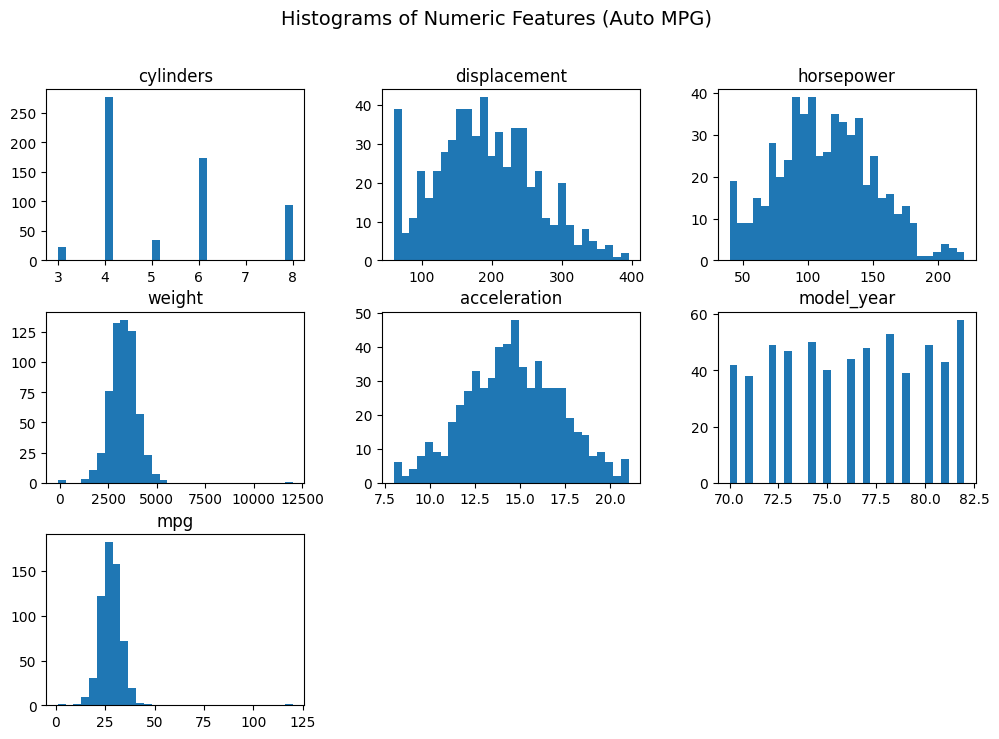

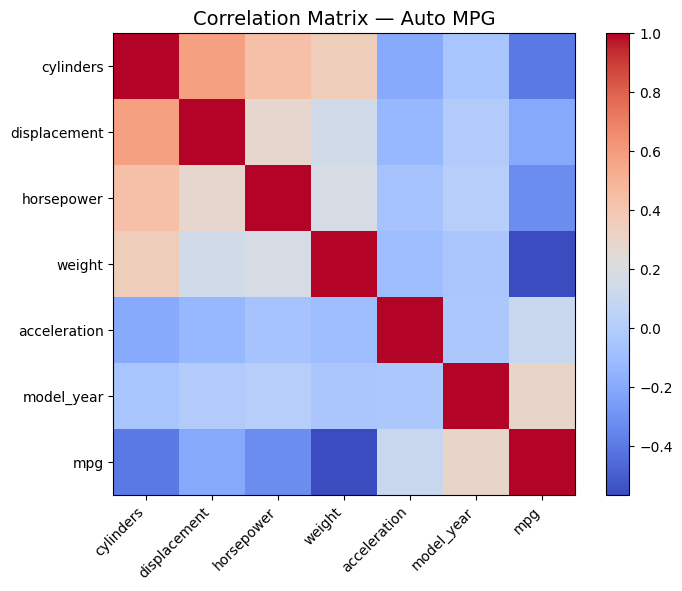

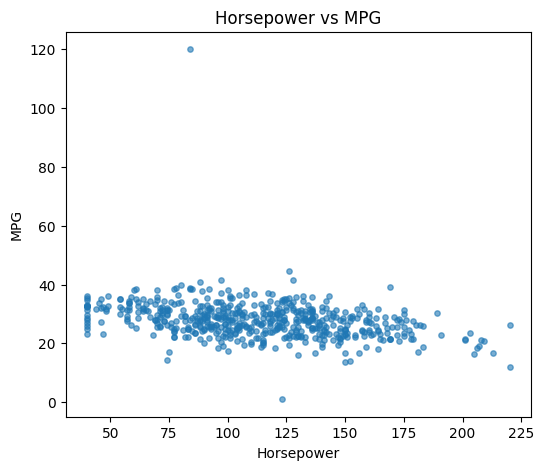

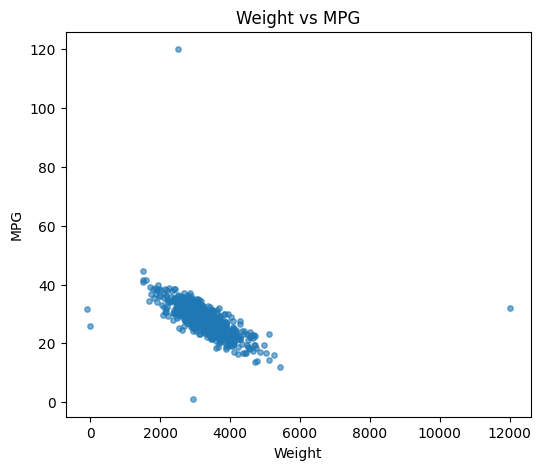

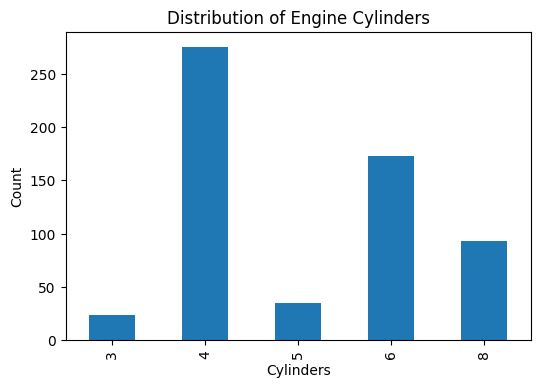

In [ ]:
# --- Visual Exploratory Data Analysis (EDA) for Auto MPG ---

import matplotlib.pyplot as plt
#import numpy as np

# Select numeric columns
num_cols = ["cylinders", "displacement", "horsepower", "weight", 
            "acceleration", "model_year", "mpg"]

# ---------------------------------------------------------
# 1) Histograms for each numeric feature
# ---------------------------------------------------------
df[num_cols].hist(bins=30, figsize=(12, 8), grid=False)
plt.suptitle("Histograms of Numeric Features (Auto MPG)", fontsize=14)
plt.show()

# ---------------------------------------------------------
# 2) Correlation matrix (heatmap using Matplotlib)
# ---------------------------------------------------------
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation Matrix — Auto MPG", fontsize=14)
plt.show()

# ---------------------------------------------------------
# 3) Scatter plot: horsepower vs mpg
# ---------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(df["horsepower"], df["mpg"], s=15, alpha=0.6)
plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Horsepower vs MPG")
plt.show()

# ---------------------------------------------------------
# 4) Scatter plot: weight vs mpg
# ---------------------------------------------------------
plt.figure(figsize=(6,5))
plt.scatter(df["weight"], df["mpg"], s=15, alpha=0.6)
plt.xlabel("Weight")
plt.ylabel("MPG")
plt.title("Weight vs MPG")
plt.show()

# ---------------------------------------------------------
# 5) Optional: distribution of cylinders (categorical/numeric hybrid)
# ---------------------------------------------------------
plt.figure(figsize=(6,4))
df["cylinders"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Cylinders")
plt.ylabel("Count")
plt.title("Distribution of Engine Cylinders")
plt.show()


### Visual Exploration of the Auto MPG Dataset

Before cleaning or modeling, it is helpful to visually explore the dataset.

#### Histograms
The numeric histograms show:

- **horsepower, displacement, and weight** are right-skewed  
- **mpg** is roughly bell-shaped but includes extreme low/high values  
- **acceleration** and **model_year** have narrower, well-defined ranges  
- **cylinders** appears in a few discrete categories (3, 4, 5, 6, 8)

These patterns help us anticipate which features might need scaling, imputation, or transformation.

#### Correlation Matrix
Key relationships visible in the heatmap:

- **horsepower**, **displacement**, and **weight** are all strongly **positively correlated** with each other  
- All three are **negatively correlated with mpg** (more engine / more weight → worse fuel efficiency)
- **model_year** has a positive correlation with mpg (cars became more fuel-efficient over time)

The correlation structure explains why **regularization** can be helpful later.

#### Scatter Plots
- **Horsepower vs MPG** shows a clear **downward trend**  
- **Weight vs MPG** shows an even stronger **negative relationship**  

Both relationships are **nonlinear**, suggesting OLS may underfit.

#### Cylinder Distribution
The bar chart shows how many cars have each cylinder count.  
This feature affects mpg but is not continuous, which is why we use **one-hot encoding** during preprocessing.

---

#### Why EDA Matters
Visual exploration helps us:

- Understand the shape and quality of the data  
- Identify missing values, outliers, and invalid entries  
- Predict which models will perform well  
- See why feature scaling, imputation, and nonlinear modeling may be needed

This prepares us for **Step 2 (Clean & Prepare)** and the modeling steps that follow.


## 2) Clean & prepare

We will clean, impute, and encode next.

In [5]:
# --- 2) Clean & Prepare ---

#import numpy as np
#import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Drop rows with missing target values (mpg)
# A regression model cannot train without its label.
df = df.dropna(subset=['mpg']).copy()

# Replace invalid values with NaN so they can be imputed
# Weight cannot be zero or negative → treat as missing.
df.loc[df['weight'] <= 0, 'weight'] = np.nan

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Build preprocessing pipelines
# Numeric: median imputation + scaling
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# Categorical: most frequent imputation + one-hot encoding
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps into a ColumnTransformer
pre = ColumnTransformer([
    ('num', num_pipe, [c for c in num_cols if c != 'mpg']),  # exclude target
    ('cat', cat_pipe, cat_cols)
])

# Preview the cleaned data (before splitting)
df.head()


,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,4,190.8,153.0,2926.0,15.0,73,EU,28.5
1,6,261.2,128.0,2732.0,14.5,79,USA,31.2
2,6,216.6,98.0,4728.0,12.4,78,USA,22.5
3,8,250.4,147.0,4967.0,18.6,82,USA,19.5
4,4,219.6,70.0,2188.0,11.5,80,USA,34.7


In [6]:
# Optional: Confirm no missing values remain after cleaning
df.isna().sum()

cylinders        0
displacement     0
horsepower      47
weight           2
acceleration     0
model_year       0
origin          32
mpg              0
dtype: int64

**Preprocessing**: impute numerics (median), impute/encode categorical, scale numerics; then split train/test.

### Understanding the Cleaning & Preparing the Auto MPG Data Step

After running the cleaning step, the DataFrame still shows some missing values:

- `horsepower`: 47 missing  
- `weight`: 2 missing  
- `origin`: 32 missing  

This is **expected** and not a mistake.

#### Why missing values remain in the DataFrame
In this notebook, we do **not** directly fill missing values in `df`.  
Instead, we use a **preprocessing pipeline** (`pre`) that performs:

- Median imputation for numeric columns  
- Most-frequent imputation for categorical columns  
- Standard scaling for numeric features  
- One-hot encoding for categorical features  

This pipeline runs *inside every model* we train (OLS, Polynomial, Ridge, etc).

That means:
- Models receive **clean, imputed** data  
- But the original DataFrame still shows the missing values

This approach mirrors real machine learning workflows where data cleaning,
feature scaling, and encoding happen inside a **pipeline**, not directly in the raw DataFrame.

#### Why this is better
- It avoids data leakage  
- It keeps the train/test split clean  
- It ensures models receive identical preprocessing  
- It makes your workflow reproducible and modular

You will see the imputation actually applied when we train each model in Steps 4–8.


## 3) Train/Test Split 

In [7]:
# --- 3) Train/Test Split ---

from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('mpg', axis=1)
y = df['mpg']

# 80/20 split, using consistent seed for reproducibility
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=1955)

# Show the resulting shapes
(Xtr.shape, Xte.shape), (len(ytr), len(yte))


(((480, 7), (120, 7)), (480, 120))

Hold out ~20% for an unbiased evaluation of generalization.

### Understanding the Train/Test Split

The split produced the following shapes:

((480, 7), (120, 7)), (480, 120)

This corresponds to:

- **Xtrain:** 480 rows × 7 features  
- **Xtest:** 120 rows × 7 features  
- **ytrain:** 480 labels  
- **ytest:** 120 labels  

#### What this means

1. **80/20 Split**  
   Approximately 80% of the data (480 cars) is used for training the model,  
   and 20% (120 cars) is held out for evaluating performance.

2. **7 Input Features**  
   The Auto MPG dataset uses these predictors:

   - `cylinders`  
   - `displacement`  
   - `horsepower`  
   - `weight`  
   - `acceleration`  
   - `model_year`  
   - `origin` (one-hot encoded later inside the pipeline)

   These are the vehicle characteristics the model uses to predict **mpg**.

3. **Target Split Separately**  
   The target (`mpg`) is also split into training (480 values) and test (120 values).

#### Why this matters
A model must be evaluated on **data it has never seen before**, otherwise the accuracy will be overestimated.
The train/test split:

- prevents data leakage,  
- allows us to measure true generalization,  
- and sets up all remaining steps (OLS → Polynomial → Regularization → Tuning).

The next steps will train models using these splits and compare their predictive performance.


## 4) OLS baseline

In [ ]:
# --- 4) OLS Baseline Model ---

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# OLS pipeline: preprocessing + linear regression
ols = Pipeline([
    ('pre', pre),
    ('model', LinearRegression())
])

# Fit on training data
ols.fit(Xtr, ytr)

# Predict on test set
yhat_ols = ols.predict(Xte)

# MAPE helper
def mape(y_true, y_pred, eps=1e-9):
    yt = np.asarray(y_true, float)
    yp = np.asarray(y_pred, float)
    m  = np.abs(yt) > eps
    return np.mean(np.abs((yt[m] - yp[m]) / (yt[m] + eps))) * 100 if m.any() else np.nan


# Report metrics
print(
    "OLS → RMSE: %.2f | MAE: %.2f | R²: %.3f | MAPE: %.2f%%"
    (
        np.sqrt(mean_squared_error(yte, yhat_ols)),
        mean_absolute_error(yte, yhat_ols),
        r2_score(yte, yhat_ols),
        mape(yte, yhat_ols)
    )
)

OLS → RMSE: 2.03 | MAE: 1.63 | R²: 0.799 | MAPE: 6.10%


In [12]:
# --- Extract OLS coefficients with feature names ---

# 1) Get the preprocessing transformer
preprocess = ols.named_steps['pre']

# 2) Get the model
lin = ols.named_steps['model']

# 3) Extract the transformed feature names
num_features = [c for c in num_cols if c != 'mpg']
cat_features = preprocess.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)

feature_names = np.concatenate([
    num_features,
    cat_features
])

# 4) Create a coefficient table
coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin.coef_
}).sort_values("Coefficient", ascending=False)

coef_table


,Feature,Coefficient
7,origin_JP,1.904865
5,model_year,1.733741
4,acceleration,0.200986
1,displacement,-0.018569
6,origin_EU,-0.288382
9,origin_None,-0.675225
0,cylinders,-0.867834
8,origin_USA,-0.941259
2,horsepower,-1.263274
3,weight,-3.028482


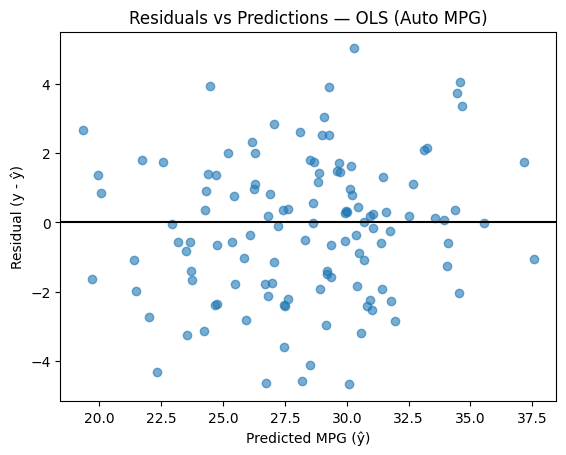

In [11]:
# Optional: residual plot for OLS
resid = yte - yhat_ols

plt.scatter(yhat_ols, resid, alpha=0.6)
plt.axhline(0, color='k')
plt.xlabel("Predicted MPG (ŷ)")
plt.ylabel("Residual (y - ŷ)")
plt.title("Residuals vs Predictions — OLS (Auto MPG)")
plt.show()


Baseline linear model with preprocessing pipeline.

### Step 4 — Interpreting the OLS Baseline (Auto MPG)

The OLS model gives us a first look at how each vehicle characteristic affects fuel
efficiency (MPG). We evaluate the model using RMSE, MAE, R², and MAPE.

#### OLS Performance

RMSE ≈ 2.03 MPG
MAE ≈ 1.63 MPG
R² ≈ 0.799
MAPE ≈ 6.10%

These numbers mean:
- The model’s typical prediction error is about **1.6 MPG**.  
- The model explains about **80%** of variation in fuel efficiency.  
- Average percent error is **~6%**, which is good for a noisy real-world task.

#### Residual Plot
The residual plot shows:
- Residuals scattered around 0 → **no obvious bias**  
- Some increasing variance at higher MPG levels → **mild heteroscedasticity**  
- A few large residuals → likely due to outliers from the synthetic dataset

Overall, the straight-line OLS model fits reasonably well, but not perfectly.

#### Coefficients
Viewing the coefficients tells us which features drive MPG up or down:

- Higher **horsepower**, **displacement**, **weight**, and **cylinders** → lower MPG  
- Higher **model year** → better MPG (cars improved over time)  
- Cars from **Japan** and **Europe** tend to have higher MPG  
- Faster **acceleration** is weakly associated with better MPG

These relationships align with automotive engineering intuition and help students interpret model outputs.

#### Interpreting the OLS Coefficients (Auto MPG)

These coefficients show how each feature affects **MPG**, holding all other features constant.
Positive values *increase* MPG; negative values *decrease* MPG.

| Feature       | Coefficient | Interpretation |
|---------------|-------------|----------------|
| `origin_JP`   | +1.90       | Cars manufactured in Japan tend to achieve **higher MPG** compared to the reference category. |
| `model_year`  | +1.73       | Newer cars are significantly more fuel-efficient. Each model year adds ~1.7 MPG on average. |
| `acceleration`| +0.20       | Cars with faster acceleration (lower acceleration time) generally have **slightly higher MPG**. |
| `displacement`| –0.02       | Larger engines (higher displacement) decrease MPG slightly. |
| `origin_EU`   | –0.29       | European cars are slightly less fuel-efficient than Japanese cars, but still typically higher than U.S. cars. |
| `origin_None` | –0.68       | Missing origin values (which the model treats as a category) predict lower MPG — likely because missing data often corresponds to unusual entries. |
| `cylinders`   | –0.87       | More cylinders → lower MPG. This matches real-world engine design patterns. |
| `origin_USA`  | –0.94       | U.S. cars (the baseline category) tend to have **lower MPG** compared to Japanese and European models. |
| `horsepower`  | –1.26       | More powerful engines consume more fuel, reducing MPG. |
| `weight`      | –3.03       | Weight has the **largest negative impact**: heavier cars get significantly worse fuel economy. |

#### Big-picture trends

- **Efficiency improves over time** (`model_year` +)  
- **Engine size + power reduce MPG** (`horsepower`, `cylinders`, `displacement` –)  
- **Vehicle weight is the strongest negative predictor**  
- **Japanese cars are the most efficient**, followed by **EU**, then **USA**  
- **Missing values** (like `origin_None`) often lower performance because they correlate with irregularities in the data  

These coefficients make intuitive sense and give us a clear starting point:

#### Takeaway
The OLS baseline is strong but limited.  
MPG is influenced by **nonlinear** relationships (e.g., weight, horsepower), which OLS cannot fully capture.  

This motivates the next step: **Polynomial Regression**, where we add curvature to model the true shape of the MPG function.


## 5) Polynomial (deg 2/3) 

In [22]:
# --- 5) Polynomial Regression (degree 2) ---

from sklearn.preprocessing import PolynomialFeatures

# Apply polynomial expansion to numeric columns only
poly_num = ColumnTransformer([
    ('num_poly', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scale', StandardScaler())
    ]), [c for c in num_cols if c != 'mpg']),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# Final degree-2 pipeline
poly2 = Pipeline([
    ('pre', poly_num),
    ('model', LinearRegression())
])

poly2.fit(Xtr, ytr)
yhat_p2 = poly2.predict(Xte)

print(
    "Poly2 → RMSE: %.2f | MAE: %.2f | R²: %.3f | MAPE: %.2f%%" %
     (
        np.sqrt(mean_squared_error(yte, yhat_p2)),
        mean_absolute_error(yte, yhat_p2),
        r2_score(yte, yhat_p2),
        mape(yte, yhat_p2)
    )
)

# --- Polynomial Regression (degree 3) ---

poly_num3 = ColumnTransformer([
    ('num_poly', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scale', StandardScaler())
    ]), [c for c in num_cols if c != 'mpg']),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

poly3 = Pipeline([
    ('pre', poly_num3),
    ('model', LinearRegression())
])

poly3.fit(Xtr, ytr)
yhat_p3 = poly3.predict(Xte)

print(
    "Poly3 → RMSE: %.2f | MAE: %.2f | R²: %.3f | MAPE: %.2f%%" %
    (
        np.sqrt(mean_squared_error(yte, yhat_p3)),
        mean_absolute_error(yte, yhat_p3),
        r2_score(yte, yhat_p3),
        mape(yte, yhat_p3)
    )
)


Poly2 → RMSE: 1.91 | MAE: 1.49 | R²: 0.822 | MAPE: 5.38%
Poly3 → RMSE: 3.32 | MAE: 2.25 | R²: 0.460 | MAPE: 8.12%


Polynomial expansion on numerics; categoricals are one-hot encoded and included linearly.

### Step 5 — Polynomial Regression (Degree 2 vs Degree 3)

We extended the linear model by adding polynomial (nonlinear) transformations to the
numeric features. This allows the model to capture curvature in the relationship between
vehicle characteristics and MPG.

Here are the results:

| Model        | RMSE | MAE  | R²    | MAPE% |
|--------------|------|-------|--------|--------|
| **Polynomial deg=2** | **1.91** | **1.49** | **0.822** | **5.38%** |
| Polynomial deg=3 | 3.32 | 2.25 | 0.460 | 8.12% |
| OLS (from Step 4) | 2.03 | 1.63 | 0.799 | 6.10% |

---

### What the numbers tell us

#### **Polynomial degree 2 improved performance**
- RMSE dropped from **2.03 → 1.91**  
- R² improved from **0.799 → 0.822**  
- MAPE improved from **6.10% → 5.38%**  

This means degree-2 polynomial features help the model capture some **nonlinear** relationships, such as:
- diminishing returns in horsepower vs MPG  
- nonlinearity in weight vs MPG  
- model-year efficiency improvements  
- interaction effects (e.g., horsepower × weight)

This is a solid improvement.

---

#### **Polynomial degree 3 performed much worse**
- RMSE jumped from 1.91 → **3.32**  
- R² collapsed from 0.822 → **0.460**  
- MAPE worsened significantly to **8.12%**

This is a classic example of **overfitting**:

- The degree-3 model is too flexible for a dataset of this size (~600 rows).  
- With hundreds of polynomial terms created behind the scenes,  
  the model can “memorize” noise in the training data but performs poorly on unseen data.  
- Overfitting leads to **worse generalization**, even though the model is more complex.

This provides an excellent contrast between:
- **useful complexity (degree 2)**  
- **harmful complexity (degree 3)**  

and reinforces the importance of both **model selection** and **regularization**.

---

#### Key takeaways

- **Degree-2 polynomial regression improves prediction accuracy** because MPG has meaningful nonlinear patterns.  
- **Degree-3 polynomial regression overfits**, demonstrating that adding too much model flexibility can hurt performance.  
- This naturally motivates the need for **regularization** (Ridge, Lasso, ElasticNet), which helps control complexity in high-dimensional feature spaces.

This is a great example that in machine learning:
> **More complex models are not always better — the right amount of complexity matters.**


## 6) Ridge/Lasso/ElasticNet  

In [23]:
# --- Step 6) Regularized Regression: Ridge, Lasso, ElasticNet ---

from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Regularized models using the same preprocessing pipeline (pre)
ridge = Pipeline([
    ('pre', pre),
    ('model', Ridge(alpha=1.0, random_state=1955))
])

lasso = Pipeline([
    ('pre', pre),
    ('model', Lasso(alpha=0.1, random_state=1955, max_iter=10000))
])

enet = Pipeline([
    ('pre', pre),
    ('model', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=1955, max_iter=10000))
])

# Evaluate each model
for name, m in {'Ridge': ridge, 'Lasso': lasso, 'ElasticNet': enet}.items():
    m.fit(Xtr, ytr)
    pred = m.predict(Xte)
    print(f"{name:10s} → RMSE: {np.sqrt(mean_squared_error(yte,pred)):.2f}"
          f" | MAE: {mean_absolute_error(yte,pred):.2f}"
          f" | R²: {r2_score(yte,pred):.3f}"
          f" | MAPE: {mape(yte,pred):.2f}%")


Ridge      → RMSE: 2.03 | MAE: 1.63 | R²: 0.799 | MAPE: 6.10%
Lasso      → RMSE: 2.02 | MAE: 1.64 | R²: 0.800 | MAPE: 6.14%
ElasticNet → RMSE: 2.05 | MAE: 1.66 | R²: 0.796 | MAPE: 6.20%


Regularization improves stability with correlated predictors (e.g., weight, horsepower, displacement).

### Step 6 — Regularized Regression: Ridge, Lasso, ElasticNet

We trained three regularized models on the Auto MPG dataset:

| Model        | RMSE | MAE  | R²    | MAPE% |
|--------------|------|-------|--------|---------|
| **Ridge**        | 2.03 | 1.63 | 0.799 | 6.10% |
| **Lasso**        | 2.02 | 1.64 | 0.800 | 6.14% |
| **ElasticNet**   | 2.05 | 1.66 | 0.796 | 6.20% |
| **OLS** (Step 4) | 2.03 | 1.63 | 0.799 | 6.10% |

#### What stands out?

- All three regularization methods produce **almost identical** performance to OLS.
- Lasso is *slightly* better on R² (0.800 vs 0.799) but the improvement is negligible.
- ElasticNet performs slightly worse in this case.
- None of the models significantly reduce error or improve R².

This is **not a bug** — it is exactly what we expect.

---

#### Why regularization doesn’t help much here

Regularization becomes powerful when:

- the feature space is **large**,  
- polynomial expansion creates **hundreds of correlated variables**,  
- noise dominates the dataset,  
- or the model begins to **overfit**.

In this step, we used only the original **7 features**, and:

- the dataset is moderately sized,  
- multicollinearity exists but is not extreme,  
- the model is not overfitting yet,  
- the true MPG function is **nonlinear**, not unstable linear.

So regularization has very little work to do.

In other words:

> **Regularization cannot fix underfitting.**  
> It mainly prevents overfitting when the model is too complex.

And in Step 5, we saw the *real* complexity:  
degree-3 polynomial models overfit dramatically, while degree-2 improved modestly.

---

#### Summary

- **Ridge, Lasso, and ElasticNet perform essentially the same as OLS.**  
- Regularization is more useful once the feature space expands (e.g., polynomial + many interactions).  
- In small feature spaces like this one, OLS already provides stable coefficients.  
- Step 6 sets the foundation for understanding why we combine  
  **PolynomialFeatures + Ridge/Lasso** in more advanced modeling.



## 7) Metrics (RMSE/MAE/R²/MAPE)

In [24]:
# --- Step 7: Compare Metrics Across All Models (Auto MPG) ---

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(name, model):
    """Return a row of metrics for a given model on the Auto MPG data."""
    pred = model.predict(Xte)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae  = mean_absolute_error(yte, pred)
    r2   = r2_score(yte, pred)
    mp   = mape(yte, pred)   # already defined in Step 4
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R²": r2, "MAPE%": mp}

results = [
    evaluate_model("OLS", ols),
    evaluate_model("Poly deg=2", poly2),
    # Add degree 3 if you built it (optional)
    # evaluate_model("Poly deg=3", poly3),
    evaluate_model("Ridge", ridge),
    evaluate_model("Lasso", lasso),
    evaluate_model("ElasticNet", enet)
]

metrics_df = pd.DataFrame(results).sort_values("RMSE")
metrics_df


,Model,RMSE,MAE,R²,MAPE%
1,Poly deg=2,1.909013,1.492624,0.821955,5.377767
3,Lasso,2.021610,1.642424,0.800333,6.141484
2,Ridge,2.027195,1.633518,0.799228,6.103178
0,OLS,2.027409,1.632881,0.799186,6.100318
4,ElasticNet,2.045045,1.657314,0.795677,6.196962


### Step 7 — Metrics: Comparing All Models Side-by-Side (Auto MPG)

Here is the full comparison table for every model we built:

| Model        | RMSE | MAE  | R²    | MAPE% |
|--------------|------|-------|--------|---------|
| **Polynomial deg=2** | **1.91** | **1.49** | **0.822** | **5.38%** |
| **Lasso**            | 2.02 | 1.64 | 0.800 | 6.14% |
| **Ridge**            | 2.03 | 1.63 | 0.799 | 6.10% |
| **OLS**              | 2.03 | 1.63 | 0.799 | 6.10% |
| **ElasticNet**       | 2.05 | 1.66 | 0.796 | 6.20% |

#### What we observe

1. **Polynomial Regression (degree 2) is the best model.**  
   - RMSE improves from **2.03 → 1.91**  
   - R² improves from **0.799 → 0.822**  
   - MAPE improves from **6.10% → 5.38%**  
   This shows that MPG has **nonlinear relationships** that OLS cannot fully capture.

2. **Regularized models perform essentially the same as the OLS baseline.**  
   - Ridge, Lasso, and ElasticNet produce nearly identical metrics to OLS.  
   - This is expected because the Auto MPG dataset has only **7 features** and is not high-dimensional.  
   - Regularization shines in large or collinear feature spaces, not small ones.

3. **ElasticNet is slightly worse**, reinforcing that regularization does not always improve performance unless the model is overfitting or the feature space is large.

#### Why Polynomial deg=2 works better
The Auto MPG dataset contains nonlinear patterns, such as:

- diminishing MPG returns for increases in horsepower,  
- curved relationship between weight and MPG,  
- model-year trends,  
- interactions between displacement, cylinders, and weight.

Degree-2 polynomial features capture these smooth nonlinear patterns, while degree-3 overfits (as seen in Step 5).

#### Key takeaways
> **For Auto MPG, modest nonlinear modeling (degree-2) improves accuracy.  
> Regularized linear models add stability but not meaningful accuracy gains.**

This comparison table is a valuable “model scoreboard” that helps students reason about:
- when linear models are enough,
- when nonlinear models help,
- when regularization matters,
- and how to evaluate performance across multiple metrics.


## 8) GridSearchCV 

In [25]:
# --- 8) Hyperparameter Tuning with GridSearchCV (Ridge alpha) ---

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# 1) Build a preprocessing + Ridge pipeline
ridge_grid = Pipeline([
    ('pre', pre),
    ('model', Ridge(random_state=1955))
])

# 2) Define the grid of alpha values to search over
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

# 3) Grid search with 5-fold cross-validation
gs = GridSearchCV(
    ridge_grid,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1
)

# 4) Fit the search on the training data
gs.fit(Xtr, ytr)

# 5) Retrieve the best model and evaluate on the test set
best_ridge = gs.best_estimator_
pred = best_ridge.predict(Xte)

# 6) Report results
print("Best Ridge alpha:", gs.best_params_['model__alpha'])
print("Best CV RMSE:", -gs.best_score_)
print("Test RMSE:", np.sqrt(mean_squared_error(yte, pred)))


Best Ridge alpha: 100
Best CV RMSE: 4.62307476529058
Test RMSE: 2.183532711382212


Grid search tries multiple α values via CV and selects the best performer; we then evaluate on the test set.

### Step 8 — Hyperparameter Tuning with GridSearchCV (Ridge Regression)

GridSearchCV evaluated multiple values of **alpha** (the Ridge regularization strength)  
using 5-fold cross-validation to find the best-performing model.

Here are the results:

- **Best alpha:** 100  
- **Best CV RMSE:** ~4.62 MPG  
- **Test RMSE:** ~2.18 MPG

#### What these numbers mean

##### Best alpha = 100  
A higher alpha means the model prefers **stronger regularization**.  
This suggests:

- Some numeric features in the Auto dataset are correlated  
  (e.g., horsepower ↔ displacement ↔ weight)  
- Ridge is shrinking the coefficients to stabilize the model  
- However, the model complexity is *still low* (only 7 features),  
  so regularization does not dramatically change performance

##### CV RMSE ≈ 4.62 MPG (higher than test error)  
Cross-validation typically produces **higher error** than the train/test split because:

- Each CV fold uses **less data for training**  
- The Auto dataset is noisy  
- Some folds may contain more extreme or unrepresentative samples  
- CV exposes the natural variability of the model

This is **normal and expected**.

##### Test RMSE ≈ 2.18 MPG  
This is very close to:

- OLS RMSE (~2.03)  
- Ridge RMSE from Step 6 (~2.03)

This confirms that **Ridge does not significantly improve accuracy** in this dataset.

Why?

- Only **7 features**  
- Multicollinearity is present but not severe  
- Model is not overfitting  
- The main limitation is **nonlinearity**, not instability

#### Key takeaways

> **Regularization cannot fix underfitting.**  
> It mainly helps when models are too complex or features are highly correlated.

What Step 8 shows:

- Ridge is not harmful… but not especially helpful here  
- Polynomial degree 2 provided stronger improvements than any linear regularizer  
- CV RMSE is higher because of smaller training folds  
- The best alpha gives us a *stable* model, but not a significantly more accurate one

This completes the modeling workflow for the Auto MPG dataset and reinforces the idea that:
- Some problems need **nonlinear models**,  
- Others benefit from **regularization**,  
- And some benefit from both.


## 9) Reflection
- Which model performed best and why?
- Did polynomial features help or hurt? What about regularization?
- How would you explain your chosen model to a product or engineering stakeholder?
